In [ ]:
import pybullet as p
import pybullet_data
import numpy as np
import time

# Connect to PyBullet GUI
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Load plane and KUKA iiwa arm
p.loadURDF("plane.urdf")
p.setGravity(0, 0, -9.81)

# Load KUKA iiwa with fixed base
robot_id = p.loadURDF("kuka_iiwa/model.urdf", [0, 0, 0], useFixedBase=True)
num_joints = p.getNumJoints(robot_id)

# Define nominal control sequence for 7 joints and 5 timesteps
nominal_control = np.array([
    [0.0, 0.1, 0.2, -0.1, 0.0, 0.05, -0.05],
    [0.1, 0.2, 0.1, -0.2, 0.1, 0.1, -0.1],
    [0.2, 0.3, 0.0, -0.3, 0.2, 0.15, -0.15],
    [0.3, 0.4, -0.1, -0.4, 0.3, 0.2, -0.2],
    [0.4, 0.5, -0.2, -0.5, 0.4, 0.25, -0.25]
])

# End-effector link index (assuming last link is the end-effector)
ee_link_index = num_joints - 1

# Set number of samples and noise characteristics
num_samples = 10
noise_mean = 0.0
noise_std = 0.05  # Standard deviation of noise

# Generate samples by adding Gaussian noise to the nominal control
samples = np.zeros((num_samples, 5, 7))
for i in range(num_samples):
    noise = np.random.normal(noise_mean, noise_std, nominal_control.shape)
    samples[i] = nominal_control + noise

# Array to store end-effector positions for all samples and timesteps
ee_positions_samples = np.zeros((num_samples, 5, 3))  # 10 samples × 5 timesteps × (x, y, z)

# Loop through each sample
for sample_idx in range(num_samples):
    print(f"\nApplying sample {sample_idx + 1}/{num_samples}...")
    
    # Apply the control sequence for this sample
    for t in range(5):
        # Apply target joint positions from the sampled sequence
        for joint_idx in range(num_joints):
            p.setJointMotorControl2(
                bodyIndex=robot_id,
                jointIndex=joint_idx,
                controlMode=p.POSITION_CONTROL,
                targetPosition=samples[sample_idx, t, joint_idx],
                force=500
            )
        
        # Simulate to allow the robot to reach the target position
        for _ in range(240):  # Simulate for 1 second (240 steps at 1/240 sec per step)
            p.stepSimulation()
            time.sleep(1. / 240.)
        
        # Get and store the end-effector position
        link_state = p.getLinkState(robot_id, ee_link_index)
        ee_positions_samples[sample_idx, t] = link_state[0]  # Store (x, y, z) position

# Print the end-effector positions for all samples and timesteps
for sample_idx in range(num_samples):
    print(f"\nEnd-effector positions for Sample {sample_idx + 1}:")
    for t in range(5):
        print(f"Timestep {t + 1}: {ee_positions_samples[sample_idx, t]}")

# Disconnect from simulation
p.disconnect()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample trajectory
for sample_idx in range(ee_positions_samples.shape[0]):
    trajectory = ee_positions_samples[sample_idx]
    x_vals = trajectory[:, 0]
    y_vals = trajectory[:, 1]
    z_vals = trajectory[:, 2]
    
    # Plot trajectory with markers at each timestep
    ax.plot(x_vals, y_vals, z_vals, marker='o', label=f"Sample {sample_idx + 1}")

# Add labels
ax.set_title("End-Effector Trajectories for 10 Samples")
ax.set_xlabel("X-axis (m)")
ax.set_ylabel("Y-axis (m)")
ax.set_zlabel("Z-axis (m)")

# Show legend
ax.legend()

# Show the plot
plt.show()


In [1]:
import pybullet as p
import pybullet_data
import numpy as np
import time

# Connect to PyBullet GUI
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Load plane and KUKA iiwa arm
p.loadURDF("plane.urdf")
p.setGravity(0, 0, -9.81)

# Load KUKA iiwa with fixed base
robot_id = p.loadURDF("kuka_iiwa/model.urdf", [0, 0, 0], useFixedBase=True)
num_joints = p.getNumJoints(robot_id)

# Define nominal control sequence for 7 joints and 5 timesteps
nominal_control = np.array([
    [0.0, 0.1, 0.2, -0.1, 0.0, 0.05, -0.05],
    [0.1, 0.2, 0.1, -0.2, 0.1, 0.1, -0.1],
    [0.2, 0.3, 0.0, -0.3, 0.2, 0.15, -0.15],
    [0.3, 0.4, -0.1, -0.4, 0.3, 0.2, -0.2],
    [0.4, 0.5, -0.2, -0.5, 0.4, 0.25, -0.25]
])

# End-effector link index (assuming last link is the end-effector)
ee_link_index = num_joints - 1

# Set number of samples and noise characteristics
num_samples = 100
noise_mean = 0.0
noise_std = 0.2  # Standard deviation of noise

# Generate samples by adding Gaussian noise to the nominal control
samples = np.zeros((num_samples, 5, 7))
for i in range(num_samples):
    noise = np.random.normal(noise_mean, noise_std, nominal_control.shape)
    samples[i] = nominal_control + noise

# Get the initial position of the end-effector (home position)
link_state = p.getLinkState(robot_id, ee_link_index)
initial_position = np.array(link_state[0])  # Store (x, y, z) as the starting point

# Array to store end-effector positions for all samples and timesteps
ee_positions_samples = np.zeros((num_samples, 6, 3))  # 10 samples × 6 timesteps × (x, y, z)

# Loop through each sample
for sample_idx in range(num_samples):

    ee_positions_samples[sample_idx, 0] = initial_position
    
    for t in range(5):
        for joint_idx in range(num_joints):
            p.setJointMotorControl2(
                bodyIndex=robot_id,
                jointIndex=joint_idx,
                controlMode=p.POSITION_CONTROL,
                targetPosition=samples[sample_idx, t, joint_idx],
                force=500
            )
        
        # Simulate to allow the robot to reach the target position
        for _ in range(240):  # Simulate for 1 second (240 steps at 1/240 sec per step)
            p.stepSimulation()
        
        # Get and store the end-effector position after applying the target position
        link_state = p.getLinkState(robot_id, ee_link_index)
        ee_positions_samples[sample_idx, t + 1] = link_state[0]  # Add to sample

# Disconnect from simulation
p.disconnect()

pybullet build time: Mar 26 2025 21:15:27


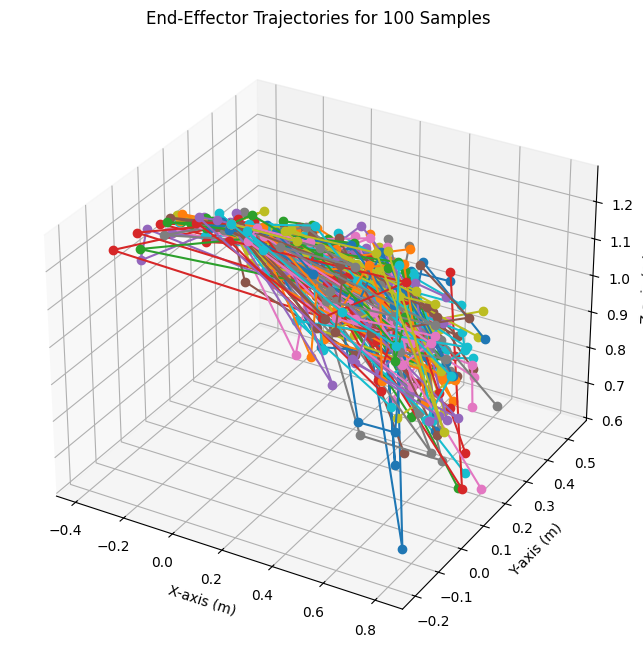

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample trajectory
for sample_idx in range(ee_positions_samples.shape[0]):
    trajectory = ee_positions_samples[sample_idx]
    x_vals = trajectory[:, 0]
    y_vals = trajectory[:, 1]
    z_vals = trajectory[:, 2]
    
    # Plot trajectory with markers at each timestep
    ax.plot(x_vals, y_vals, z_vals, marker='o', label=f"Sample {sample_idx + 1}")

# Add labels
ax.set_title("End-Effector Trajectories for 100 Samples")
ax.set_xlabel("X-axis (m)")
ax.set_ylabel("Y-axis (m)")
ax.set_zlabel("Z-axis (m)")

# Show legend
# ax.legend()

# Show the plot
plt.show()